# CNN

출처: https://github.com/SLCFLAB/Data-Science-Python, https://github.com/Harry24k/Pytorch-Basic


GPU 사용하는 방법: 런타임 -> 런타임 유형 변경 -> GPU





In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np
import random
import os

import matplotlib.pyplot as plt
%matplotlib inline

#### torchvision.datasets.MNIST 설명
https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST 

* train (bool, optional) – If True, creates dataset from train-images
* transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version.

## Load data

In [3]:
train_data = dsets.MNIST(root='data/',
                         train=True,
                         transform=transforms.ToTensor(), #데이터를 텐서형태로 바꾸어줌 (0~255를 0~1 사이 값으로) #PILToTensor
                         download=True) #해당 경로에 이미 데이터 있으면 다운 생략

test_data = dsets.MNIST(root='data/',
                        train=False,
                        transform=transforms.ToTensor(),
                        download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/home/tako/anaconda3/envs/torch/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
train_data[0] #28x28 tensor, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

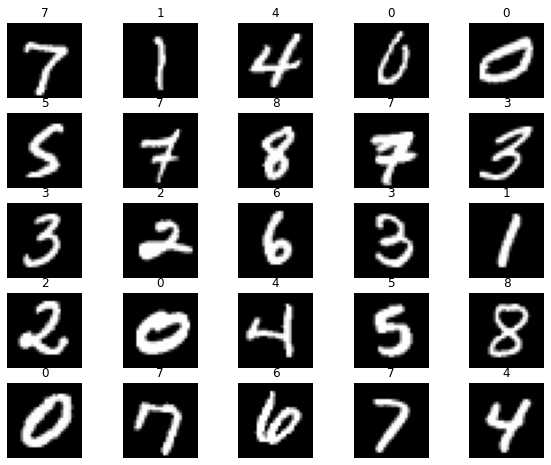

In [5]:
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [6]:
print(len(train_data))
print(len(test_data))

60000
10000


MNIST 학습 데이터 셋은 총 60000장으로 구성되어 있음.  
6만장이라는 데이터 학습을 한 번에 하려면 시간이 굉장히 비효율적으로 리소스를 사용하기 때문에 Batch size로 나누어주어 쪼개서 학습을 하겠다는 의미.  
여기서는 batch size를 100 -> 총 600번의 step을 통해 1 epoch을 돌게 된다. 
* dataloader: https://pytorch.org/docs/stable/data.html 

In [7]:
batch_size = 100 # 한번에 할 연산량

#데이터를 100개씩 임의로 불러옴 
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)

In [8]:
len(train_loader)

600

### CNN 모델 구조
* neural network 모델을 선언할 때는 거의 대부분 nn.Module을 상속받는다.
* __init__ 함수를 통해서 클래스를 초기화
* nn.Conv2d (input_channel, out_channel, kernel size)
  - 입력 데이터로부터 특징을 추출하는 층
  - kernel size can be tuple, int
  - https://bcho.tistory.com/1149
* convolution layer의 activation function은 추출한 특성을 비선형 값으로 바꿔 주는 역할
  - CNN에서 sigmoid가 아닌 ReLU 사용하는 이유? "gradinet vanishing" 때문에 역전파가 잘 안일어남
* fc_layer: 컨볼루셔널 계층에서 특징이 추출이 되었으면 이 추출된 특징 값을 모델에 넣어서 분류

In [9]:
class CNN(nn.Module): #CNN이라는 클래스는 nn.Module을 상속받는다.
    def __init__(self):
        super(CNN, self).__init__() #초기화하지 않으면 부모 클래스를 상속받을 수 없음
        
        self.conv_layer = nn.Sequential( ## To DO: 주석으로 달아둔 shape과 다음 layer를 참고해 ?를 채워주세요
                                #input: 100(batch) * 28 * 28
            nn.Conv2d(1, 16, 5), #[100, 16 ,24,24]: batch, channel, width, height
            nn.ReLU(),
            nn.Conv2d(16, 32, 5),#[100,32,20,20]
            nn.ReLU(),
            nn.MaxPool2d(2, 2),# [100,32,10,10]
            nn.Conv2d(32, 64, 5),# [100,64,6,6]
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # [100,64,3,3] -> 여기서 batch 빼고 나머지 64*3*3
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3, 100), #여기서 64*3*3 -> 100 
            nn.ReLU(),
            nn.Linear(100, 10)#100 -> 10
        )       
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

In [10]:
model = CNN().cuda() ## GPU 사용

* CrossEntropy: classification에서 자주 사용되는 loss function
* optimizer: SGD(stochastic gradient descent). 
큰 스텝씩 움직이면서 경사 하강하기 때문에, 일반 GD보다 수렴 속도가 빠름 

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

## Train model

#### train의 기본 구조
* output = model(data) : 모델에서 정의한 forward 단계실행. 모델에 data를 전달하여 예상하는 label 값 계산
* cost = criterion(output, label) : 모델에서 나온 output과 label을 이용해 loss 계산
* optimizer.zero_grad() : 갱신할 Variable들에 대한 모든 변화도를 0으로 만듬
* cost.backward() : 역전파 단계 실행. 모델의 Variable들에 대한 손실의 변화도를 계산
* optimizer.step() : 가중치 갱신
* epoch은 전체 트레이닝 셋이 신경망을 통과한 횟수를 의미함.

In [12]:
num_epochs = 3

* .zero_grad(): 역전파 실행하기 전에 그래디언트를 0으로 만듦. (초기화)

In [14]:
for epoch in range(num_epochs):

    total_batch = len(train_data) // batch_size #60000//100 = 600 steps per 1 epoch

    #train_loader : MNIST의 train 데이터를 받아오는 함수. data, label 값을 return 해줌. 
    for i, (batch_images, batch_labels) in enumerate(train_loader):

        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad() 
        cost.backward()
        optimizer.step()

        if (i+1) % 300 == 0: #300, 600번째 스텝에 대해서만 프린트(한 에폭당)
            print('Epoch [%d/%d], lter [%d/%d], Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

Epoch [1/3], lter [300/600], Loss: 0.2670
Epoch [1/3], lter [600/600], Loss: 0.2100
Epoch [2/3], lter [300/600], Loss: 0.1309
Epoch [2/3], lter [600/600], Loss: 0.1484
Epoch [3/3], lter [300/600], Loss: 0.1556
Epoch [3/3], lter [600/600], Loss: 0.1239


## Test model

In [ ]:
correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1) #outputs.data 행마다 최대 (torch.max(tensor, dim))
    #최댓값 자체는 필요없으므로 언더바로 표현, predicted는 인덱스 나타냄(즉, 라벨)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

Accuracy of test images: 95.960000 %


In [ ]:
print(labels[:10])
classes = ('0', '1','2','3','4','5','6','7','8','9')
outputs = model(images)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(10)))

tensor([8, 9, 0, 1, 2, 3, 4, 5, 6, 7])
Predicted:      8     9     0     1     3     7     4     5     6     7
